## Makemore Pt 2

This notebook implements a MLP character model to predict the next character given more characters of context

The first model implemented in makemore.ipynb only considered the previous character for context and learned to predict it. This next model based on the paper by _Bengio et al_.

1. associate with each character in the vocabulary a distributed character feature vector (a real valued vector in Rm),
2. express the joint probability function of character sequences in terms of the feature vectors
of these characters in the sequence, and
3. learn simultaneously the character feature vectors and the parameters of that probability
function.

In [34]:
from collections import deque
import random
import torch
import torch.nn.functional as F


words = open('names.txt').read().splitlines()

In [35]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

## Architecture Overview

- Inputs: N Characters * E dimensions feature vectors

E.g. if using 3 context chars and encoding each as a vector in 3 dimensional space, then each input to the NN is a 9 dimensional vector.

- Layers:

1) Embedding lookup : takes in each of N characters,outputs a feature vector for each.
2) Hidden layer 1 + tanh activation
3) Output layer 2 + softmax activation

Output:

Probability distribution of the next character given those feature vectors

In [36]:
# Utility dicts
stoi = {c:i+1 for i,c in enumerate(sorted(set("".join(words))))}
stoi["."] = 0
itos = {i:c for c,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [37]:
# Create the dataset
CONTEXT_WINDOW = 3
def build_dataset(wds):
    X,Y = [],[]
    for w in wds:
        window = deque([0]*CONTEXT_WINDOW,maxlen=CONTEXT_WINDOW)
        for c in w + ".":
            ix = stoi[c]
            X.append(list(window))
            Y.append(ix)
            # print(''.join(itos[i] for i in window), '--->', itos[ix])
            window.append(ix)
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape,Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
Xtr[0,:]

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


tensor([0, 0, 0])

In [38]:
# Define the embedding mapping, takes in a in one hot encoding w 27 classes -> outputs vector in Rn
N = 10
C = torch.randn((27,N))

To get the embeddings we just index C with our

In [39]:
Xtr

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        ...,
        [15, 12,  4],
        [12,  4,  1],
        [ 4,  1, 14]])

In [40]:
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 10])

### Hidden layer 1

In [41]:
# Multiple ways to make the inputs 2d
# torch.cat([emb[:, 0, :],emb[:, 1, :], emb[:, 2, :]],dim=1)
# torch.cat(torch.unbind(emb,dim = 1), dim=1)
emb.view(-1,N*3)


tensor([[ 0.6166,  1.3120, -0.8144,  ..., -0.5286,  0.0187,  0.9310],
        [ 0.6166,  1.3120, -0.8144,  ...,  1.1552,  0.6368, -0.3370],
        [ 0.6166,  1.3120, -0.8144,  ..., -2.9766, -0.6079, -0.7653],
        ...,
        [-1.7260, -2.0874,  0.8971,  ..., -0.5451,  0.9792, -1.5454],
        [ 0.5954,  1.3703, -0.6251,  ...,  0.6059, -0.4174,  0.2866],
        [ 0.0725,  0.7623, -1.1205,  ..., -0.2507, -0.1757, -0.7395]])

In [42]:
W1 =  torch.randn((N*CONTEXT_WINDOW,300))
b1 = torch.randn(300)
(W1.shape,b1.shape)

(torch.Size([30, 300]), torch.Size([300]))

In [43]:
# Pass through 300 neuron hidden layer
h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)

In [44]:
h

tensor([[ 0.1060, -0.8517,  0.9815,  ..., -0.3514, -0.9774,  1.0000],
        [ 1.0000,  0.6771, -0.9993,  ...,  0.9995,  0.9963, -0.6119],
        [-0.9408, -1.0000,  0.9940,  ...,  0.0280, -0.1465, -0.9971],
        ...,
        [-1.0000,  0.8506, -0.6235,  ...,  0.9700,  1.0000,  0.9939],
        [ 1.0000,  0.9984, -0.8642,  ..., -0.9295, -0.7988, -1.0000],
        [-0.8691, -1.0000,  0.9984,  ..., -0.3652, -1.0000,  0.6219]])

### Output layer

In [45]:
W2 = torch.randn((300,27))
b2 = torch.randn(27)

In [46]:
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# prob.shape

In [47]:
# loss = -prob[torch.arange(100), Ytr[:100]].log().mean()
# loss

In [48]:
# cross_entropy takes the unnormalized logits then works out the cross-entropy loss, we don't need to normalize ourselves, which is inefficient
F.cross_entropy(logits, Ytr)

tensor(31.0193)

In [49]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [50]:
# Num parameters
sum(p.nelement() for p in parameters)

17697

### Training loop

Training set: used to train
Dev/validation: used to train/tune hyperparameters
Test: used to test

Notes:

- If training dataset contains far fewer examples than the number of parameters, the model will overfit the training set and show very low loss, does not mean the model is good (it won't generalise)
- While we could iterate on full dataset (forward + backward), this is inefficient and not done in practice -> use random mini-batches of the data which makes the forward/backward pass far more efficient

In [51]:
# Generate learning rates to try
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [52]:
losses = []
for i in range(1000):
    # Forward pass
    ix = torch.randint(0, Xtr.shape[0], (32,))
    #Only forward + backward the mini batch
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data -= p.grad * lr
    losses.append(loss.item())
    print(loss.item())



28.583473205566406
35.04237747192383
32.959049224853516
28.272048950195312
34.39179611206055
27.640472412109375
32.42833709716797
29.67731475830078
31.277042388916016
30.866973876953125
34.68759536743164
30.652910232543945
29.353557586669922
30.243677139282227
31.443450927734375
29.20188331604004
32.76394271850586
30.190872192382812
29.245315551757812
32.3044319152832
29.054319381713867
32.51646423339844
29.11195182800293
30.17214012145996
32.733741760253906
30.783775329589844
28.93780517578125
29.437973022460938
27.9128360748291
35.42225646972656
29.071889877319336
28.805959701538086
31.64217185974121
24.008695602416992
31.786298751831055
35.85955810546875
29.217227935791016
28.105873107910156
29.39366340637207
30.989870071411133
28.635732650756836
28.469310760498047
37.70681381225586
30.232101440429688
30.60433006286621
26.022184371948242
29.109519958496094
33.82834243774414
34.42682647705078
35.454158782958984
26.806364059448242
31.122907638549805
28.79092025756836
23.61751365661621

Finding the optimal learning rate (tuning)

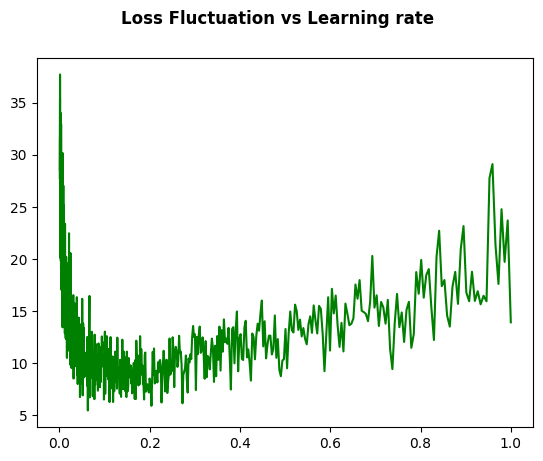

In [53]:
import matplotlib.pyplot as plt

plt.plot(lrs, losses, "g" )
plt.suptitle("Loss Fluctuation vs Learning rate", fontweight='bold')
plt.show()

From the graph we see the loss destabilizes with laearning rates >= to 0.15.

Thus we can infer suitable learning rates are around 0.1.

Best way to train is to start around 0.1 then learn the finer details with smaller lr around 0.01

In [89]:
losses = []
steps = []
for i in range(30000):
    # Forward pass
    ix = torch.randint(0, Xtr.shape[0], (64,))
    #Only forward + backward the mini batch
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.01 if i < 10000 else 0.001
    for p in parameters:
        p.data -= p.grad * lr
    steps.append(i)
    losses.append(loss.item())
    print(loss.item())


2.0590970516204834
2.1257057189941406
2.4443435668945312
2.288548231124878
2.164032220840454
2.1058545112609863
2.181922674179077
2.0318500995635986
1.9845573902130127
1.9069035053253174
2.1718780994415283
2.087991714477539
2.4317984580993652
2.071213960647583
1.8362605571746826
2.329859495162964
2.3252179622650146
1.9003180265426636
2.096039295196533
1.9698199033737183
2.1540558338165283
2.1356732845306396
2.2435576915740967
2.164146900177002
2.1484830379486084
1.962903618812561
1.8135050535202026
1.8196543455123901
2.209846258163452
2.301131010055542
2.160254955291748
1.8484463691711426
1.99299955368042
2.2751097679138184
2.4659855365753174
1.932134985923767
1.9827214479446411
2.066077470779419
1.891515851020813
2.286062240600586
1.86835777759552
2.143975019454956
2.1948680877685547
2.148775577545166
1.8637698888778687
2.117762565612793
2.0008697509765625
2.338031530380249
1.9361995458602905
2.3189597129821777
2.35455060005188
2.1885039806365967
1.953262209892273
2.2739274501800537
2

after training on the training set we look at the train/dev set loss

In [90]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1313, grad_fn=<NllLossBackward0>)

In [91]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2084, grad_fn=<NllLossBackward0>)

In [92]:
emb = C[Xte]
h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2055, grad_fn=<NllLossBackward0>)

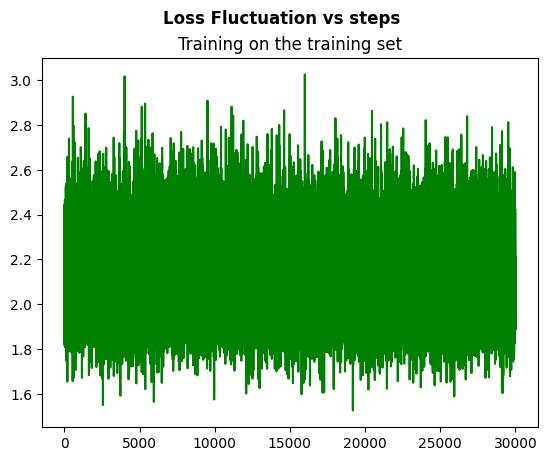

In [93]:
import matplotlib.pyplot as plt

plt.plot(steps, losses, "g" )
plt.suptitle("Loss Fluctuation vs steps", fontweight='bold')
plt.title("Training on the training set")
plt.show()

There seems to be a lot of thrashing with batch size 32-> we can try increasing batch size to reduce this

In [94]:
C

tensor([[ 1.4544e+00, -2.6698e+00,  4.8154e-02, -6.5948e+00, -7.9209e-01,
          2.3570e+00,  1.7897e+00, -1.5746e+00,  8.6159e-01,  4.0394e+00],
        [-2.7120e+00, -7.8163e-01, -2.8238e-02,  6.6525e+00, -3.9821e+00,
         -6.2897e+00, -5.2497e+00,  2.4774e+00, -3.0586e+00,  3.9618e+00],
        [ 9.9039e-02, -6.0152e-01, -8.0281e-01,  6.0623e-01,  1.2221e+00,
         -1.9526e-01, -9.3509e-02, -4.9849e-01,  1.1912e+00, -3.3529e-01],
        [ 4.3999e-01, -5.9103e-01, -2.0973e-01, -4.2612e-01,  5.5212e-01,
         -1.4769e+00, -4.4726e-01, -7.0874e-01,  6.9393e-01, -2.7723e-01],
        [-4.5733e-02, -2.7602e-01, -7.7350e-01,  2.8298e-01,  1.0737e+00,
         -3.0487e-01,  5.2021e-02, -6.7035e-01,  1.3578e+00, -1.2687e-01],
        [-6.1270e+00, -4.9806e-01, -1.8935e+00,  1.7429e-02,  2.8428e+00,
          1.2243e+00,  3.0831e+00,  1.5937e+00,  1.4823e+00, -1.7712e+00],
        [-2.6043e-01, -6.0886e-01, -2.9703e-01, -7.6673e-01, -3.0440e-01,
         -8.3460e-01, -4.1181e-0

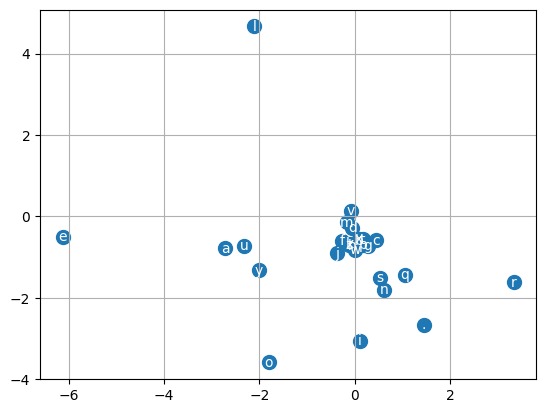

In [95]:
plt.scatter(C[:,0].data,C[:,1].data, s=100)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [97]:
for _ in range(100):

    out = []
    context = [0] * CONTEXT_WINDOW
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

evor.
younmarionno.
yaran.
bryn.
aleryn.
rivaleia.
arto.
zatalina.
nabis.
llia.
elie.
hawyaaya.
ireshi.
emice.
kyran.
quinleiah.
adder.
eimyn.
illyn.
aley.
emriel.
kaizerin.
hami.
kossy.
nyellia.
chihh.
aafinteremon.
abduliyah.
mar.
ami.
rawell.
imen.
tayah.
gtida.
skeyonni.
jaya.
dyl.
jeson.
jansha.
laidy.
jat.
brixh.
tredanshisaan.
kean.
ten.
ida.
rosii.
arriya.
casan.
vcyn.
dairelyn.
danaya.
aine.
symosslavieraad.
bexh.
michavess.
esy.
jacplynen.
maria.
anne.
aden.
malennelizekariell.
habbd.
tayona.
gamonter.
maristerra.
aulie.
madsi.
allu.
trice.
seliz.
alec.
rilanuarvitzik.
traya.
dory.
jaserron.
olo.
amon.
mara.
saqay.
mel.
fachithanima.
bri.
auri.
kehia.
ketter.
zayna.
khitlakario.
isma.
sam.
yaiel.
adzayira.
ana.
bar.
gio.
malla.
josseerceer.
skin.
joa.
mako.


With the current network configuration, can achieve  loss of 2.2055 on the test set. It seems with the 18000ish parameters and enough steps, we begin to overfit on the training set as the train losses drift away from the test losses